In [1]:
# format the book
%matplotlib inline
import sys
from __future__ import division, print_function
import sys
sys.path.insert(0,'../code')
import book_format
book_format.load_style('../code')

# Decision Analysis

## The *Price is Right* problem

On November 1, 2007, contestants named Letia and Nathaniel appeared on
*The Price is Right*, an American game show. They competed
in a game called *The Showcase*, where the objective is to
guess the price of a showcase of prizes. The contestant who comes
closest to the actual price of the showcase, without going over, wins
the prizes.

Nathaniel went first. His showcase included a dishwasher, a wine
cabinet, a laptop computer, and a car. He bid \$26,000.

Letia’s showcase included a pinball machine, a video arcade game, a pool
table, and a cruise of the Bahamas. She bid \$21,500.

The actual price of Nathaniel’s showcase was \$25,347. His bid was too
high, so he lost.

The actual price of Letia’s showcase was \$21,578. She was only off by
\$78, so she won her showcase and, because her bid was off by less than
\$250, she also won Nathaniel’s showcase.

For a Bayesian thinker, this scenario suggests several questions:

1.  Before seeing the prizes, what prior beliefs should the contestant
    have about the price of the showcase?

2.  After seeing the prizes, how should the contestant update those
    beliefs?

3.  Based on the posterior distribution, what should the contestant bid?

The third question demonstrates a common use of Bayesian analysis:
decision analysis. Given a posterior distribution, we can choose the bid
that maximizes the contestant’s expected return.

This problem is inspired by an example in Cameron Davidson-Pilon’s book,
*Bayesian Methods for Hackers*. The code I wrote for this
chapter is available from <http://thinkbayes.com/price.py>; it reads
data files you can download from
<http://thinkbayes.com/showcases.2011.csv> and
<http://thinkbayes.com/showcases.2012.csv>. For more information see
Section [download].

## The prior

To choose a prior distribution of prices, we can take advantage of data
from previous episodes. Fortunately, fans of the show keep detailed
records. When I corresponded with Mr. Davidson-Pilon about his book, he
sent me data collected by Steve Gee at <http://tpirsummaries.8m.com>. It
includes the price of each showcase from the 2011 and 2012 seasons and
the bids offered by the contestants.

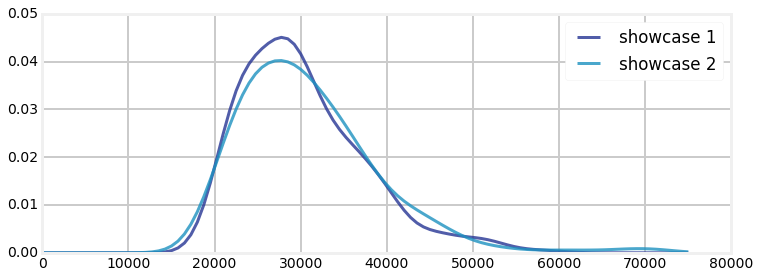

In [2]:
from price import *
import matplotlib.pyplot as plt
player1, player2 = MakePlayers(path='../code')
MakePrice1(player1, player2)
plt.legend();

This shows the distribution of prices for these
showcases. The most common value for both showcases is around \$28,000,
but the first showcase has a second mode near \$50,000, and the second
showcase is occasionally worth more than \$70,000.

These distributions are based on actual data, but they have been
smoothed by Gaussian kernel density estimation (KDE). Before we go on, I
want to take a detour to talk about probability density functions and
KDE.

## Probability density functions

So far we have been working with probability mass functions, or PMFs. A
PMF is a map from each possible value to its probability. In my
implementation, a Pmf object provides a method named Prob
that takes a value and returns a probability, also known as a
**probability mass**.

A **probability density function**, or PDF, is the
continuous version of a PMF, where the possible values make up a
continuous range rather than a discrete set.

In mathematical notation, PDFs are usually written as functions; for
example, here is the PDF of a Gaussian distribution with mean 0 and
standard deviation 1: 

$$f(x) = \frac{1}{\sqrt{2 \pi}} \exp(-x^2/2)$$

For a given value of $x$, this function computes a probability density. A
density is similar to a probability mass in the sense that a higher
density indicates that a value is more likely.

But a density is not a probability. A density can be 0 or any positive
value; it is not bounded, like a probability, between 0 and 1.

If you integrate a density over a continuous range, the result is a
probability. But for the applications in this book we seldom have to do
that.

Instead we primarily use probability densities as part of a likelihood
function. We will see an example soon.

## Representing PDFs

To represent PDFs in Python, `thinkbayes.py` provides a class
named `Pdf`. `Pdf` is an **abstract type**, which means that it defines the interface a Pdf is
supposed to have, but does not provide a complete implementation. The
`Pdf` interface includes two methods, `Density`
and `MakePmf`:

In [3]:
class Pdf(object):

    def Density(self, x):
        raise UnimplementedMethodException()

    def MakePmf(self, xs):
        pmf = Pmf()
        for x in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf

`Density` takes a value, `x`, and returns the
corresponding density. `MakePmf` makes a discrete
approximation to the PDF.

`Pdf` provides an implementation of `MakePmf`, but
not `Density`, which has to be provided by a child class.

A **concrete type** is a child class that extends an
abstract type and provides an implementation of the missing methods. For
example, `GaussianPdf` extends `Pdf` and provides
`Density`:

In [4]:
class GaussianPdf(Pdf):

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def Density(self, x):
        return scipy.stats.norm.pdf(x, self.mu, self.sigma)

`__init__` takes `mu` and `sigma`, which are the
mean and standard deviation of the distribution, and stores them as
attributes.

`Density` uses a function from `scipy.stats` to
evaluate the Gaussian PDF. The function is called `norm.pdf`
because the Gaussian distribution is also called the “normal”
distribution.

The Gaussian PDF is defined by a simple mathematical function, so it is
easy to evaluate. And it is useful because many quantities in the real
world have distributions that are approximately Gaussian.

But with real data, there is no guarantee that the distribution is
Gaussian or any other simple mathematical function. In that case we can
use a sample to estimate the PDF of the whole population.

For example, in *The Price Is Right* data, we have 313
prices for the first showcase. We can think of these values as a sample
from the population of all possible showcase prices.

This sample includes the following values (in order):

$$28800, 28868, 28941, 28957, 28958$$ 

In the sample, no values appear
between 28801 and 28867, but there is no reason to think that these
values are impossible. Based on our background information, we expect
all values in this range to be equally likely. In other words, we expect
the PDF to be fairly smooth.

Kernel density estimation (KDE) is an algorithm that takes a sample and
finds an appropriately smooth PDF that fits the data. You can read
details at <http://en.wikipedia.org/wiki/Kernel_density_estimation>.

`scipy` provides an implementation of KDE and
`thinkbayes` provides a class called
`EstimatedPdf` that uses it:

In [5]:
class EstimatedPdf(Pdf):

    def __init__(self, sample):
        self.kde = scipy.stats.gaussian_kde(sample)

    def Density(self, x):
        return self.kde.evaluate(x)

`__init__` takes a sample and computes a kernel density estimate. The
result is a `gaussian_kde` object that provides an `evaluate`
method.

`Density` takes a value, calls `gaussian_kde.evaluate`, and
returns the resulting density.

Finally, here’s an outline of the code I used to generate
Figure [fig.price1]:

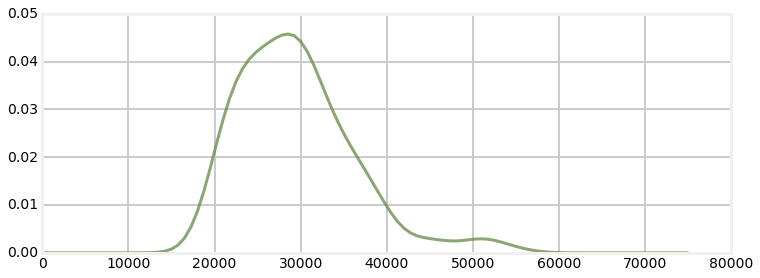

In [6]:
data = ReadData(path='../code')
cols = zip(*data)
price1, price2, bid1, bid2, diff1, diff2 = cols

pdf = thinkbayes.EstimatedPdf(price1)
low, high = 0, 75000
n = 101
xs = numpy.linspace(low, high, n) 
pdf.kde.evaluate([3, 3])

pmf = pdf.MakePmf(xs)
thinkplot.Pmfs([pmf])

`pdf` is a `Pdf` object, estimated by KDE.
`pmf` is a Pmf object that approximates the Pdf by evaluating
the density at a sequence of equally spaced values.

`linspace` stands for “linear space.” It takes a range,
`low` and `high`, and the number of points,
`n`, and returns a new `numpy` array with
`n` elements equally spaced between `low` and
`high`, including both.

And now back to *The Price is Right*.

## Modeling the contestants

The PDFs in Figure [fig.price1] estimate the distribution of possible
prices. If you were a contestant on the show, you could use this
distribution to quantify your prior belief about the price of each
showcase (before you see the prizes).

To update these priors, we have to answer these questions:

1.  What data should we consider and how should we quantify it?

2.  Can we compute a likelihood function; that is, for each hypothetical
    value of `price`, can we compute the conditional
    likelihood of the data?

To answer these questions, I am going to model the contestant as a
price-guessing instrument with known error characteristics. In other
words, when the contestant sees the prizes, he or she guesses the price
of each prize—ideally without taking into consideration the fact that
the prize is part of a showcase—and adds up the prices. Let’s call this
total `guess`.

Under this model, the question we have to answer is, “If the actual
price is `price`, what is the likelihood that the
contestant’s estimate would be `guess`?”

Or if we define

```python
error = price - guess
```
then we could ask, “What is the likelihood that the contestant’s
estimate is off by `error`?”

To answer this question, we can use the historical data again.
Figure [fig.price2] shows the cumulative distribution of
`diff`, the difference between the contestant’s bid and the
actual price of the showcase.

The definition of diff is

```python
diff = price - bid
```

When `diff` is negative, the bid is too high. As an aside, we
can use this distribution to compute the probability that the
contestants overbid: the first contestant overbids 25% of the time; the
second contestant overbids 29% of the time.

We can also see that the bids are biased; that is, they are more likely
to be too low than too high. And that makes sense, given the rules of
the game.

Finally, we can use this distribution to estimate the reliability of the
contestants’ guesses. This step is a little tricky because we don’t
actually know the contestant’s guesses; we only know what they bid.

So we’ll have to make some assumptions. Specifically, I assume that the
distribution of `error` is Gaussian with mean 0 and the same
variance as `diff`.

The `Player` class implements this model:

```python
class Player(object):

    def __init__(self, prices, bids, diffs):
        self.pdf_price = thinkbayes.EstimatedPdf(prices)
        self.cdf_diff = thinkbayes.MakeCdfFromList(diffs)

        mu = 0
        sigma = numpy.std(diffs)
        self.pdf_error = thinkbayes.GaussianPdf(mu, sigma)
```

`prices` is a sequence of showcase prices, `bids`
is a sequence of bids, and `diffs` is a sequence of diffs,
where again `diff = price - bid`.

`pdf_price` is the smoothed PDF of prices, estimated by KDE. `cdf_diff`
is the cumulative distribution of `diff`, which we saw in
Figure [fig.price2]. And `pdf_error` is the PDF that characterizes the
distribution of errors; where `error = price - guess`.

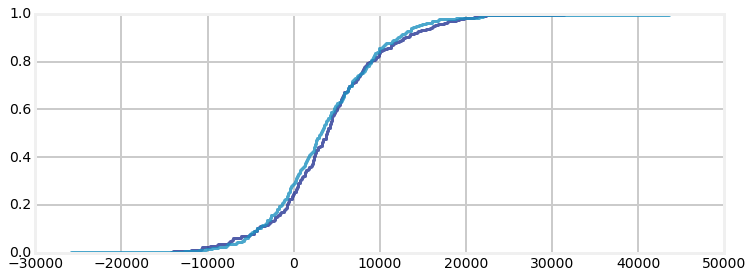

In [7]:
MakePrice2(player1, player2)

Again, we use the variance of `diff` to estimate the variance
of `error`. This estimate is not perfect because contestants’
bids are sometimes strategic; for example, if Player 2 thinks that
Player 1 has overbid, Player 2 might make a very low bid. In that case
`diff` does not reflect `error`. If this happens a
lot, the observed variance in `diff` might overestimate the
variance in `error`. Nevertheless, I think it is a reasonable
modeling decision.

As an alternative, someone preparing to appear on the show could
estimate their own distribution of `error` by watching
previous shows and recording their guesses and the actual prices.

## Likelihood

Now we are ready to write the likelihood function. As usual, I define a
new class that extends `thinkbayes.Suite`:

In [8]:
class Price(thinkbayes.Suite):

    def __init__(self, pmf, player):
        thinkbayes.Suite.__init__(self, pmf)
        self.player = player
        
    def Likelihood(self, data, hypo):
        price = hypo
        guess = data

        error = price - guess
        like = self.player.ErrorDensity(error)

        return like

`pmf` represents the prior distribution and
`player` is a Player object as described in the previous
section. In `Likelihood` `hypo` is the hypothetical price of the showcase.
`data` is the contestant’s best guess at the price.
`error` is the difference, and `like` is the
likelihood of the data, given the hypothesis.

`ErrorDensity` is defined in `Player`:

```python
# class Player:

    def ErrorDensity(self, error):
        return self.pdf_error.Density(error)
```

`ErrorDensity` works by evaluating `pdf_error` at the given
value of `error`. The result is a probability density, so it
is not really a probability. But remember that `Likelihood`
doesn’t need to compute a probability; it only has to compute something
*proportional* to a probability. As long as the constant of
proportionality is the same for all likelihoods, it gets canceled out
when we normalize the posterior distribution.

And therefore, a probability density is a perfectly good likelihood.

## Update

`Player` provides a method that takes the contestant’s guess
and computes the posterior distribution:

```python
# class Player
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self)
        self.posterior = self.prior.Copy()
        self.posterior.Update(guess)
```

`PmfPrice` generates a discrete approximation to the PDF of
price, which we use to construct the prior.

`PmfPrice` uses `MakePmf`, which evaluates
`pdf_price` at a sequence of values:

```python
# class Player
    n = 101
    price_xs = numpy.linspace(0, 75000, n)

    def PmfPrice(self):
        return self.pdf_price.MakePmf(self.price_xs)
```

To construct the posterior, we make a copy of the prior and then invoke
`Update`, which invokes `Likelihood` for each
hypothesis, multiplies the priors by the likelihoods, and renormalizes.

So let’s get back to the original scenario. Suppose you are Player 1 and
when you see your showcase, your best guess is that the total price of
the prizes is \$20,000.

Figure [fig.price3] shows prior and posterior beliefs about the actual
price. The posterior is shifted to the left because your guess is on the
low end of the prior range.

On one level, this result makes sense. The most likely value in the
prior is \$27,750, your best guess is \$20,000, and the mean of the
posterior is somewhere in between: \$25,096.

On another level, you might find this result bizarre, because it
suggests that if you *think* the price is \$20,000, then
you should *believe* the price is \$24,000.

To resolve this apparent paradox, remember that you are combining two
sources of information, historical data about past showcases and guesses
about the prizes you see.

We are treating the historical data as the prior and updating it based
on your guesses, but we could equivalently use your guess as a prior and
update it based on historical data.

If you think of it that way, maybe it is less surprising that the most
likely value in the posterior is not your original guess.

## Optimal bidding

Now that we have a posterior distribution, we can use it to compute the
optimal bid, which I define as the bid that maximizes expected return
(see <http://en.wikipedia.org/wiki/Expected_return>).

I’m going to present the methods in this section top-down, which means I
will show you how they are used before I show you how they work. If you
see an unfamiliar method, don’t worry; the definition will be along
shortly.

To compute optimal bids, I wrote a class called
`GainCalculator`:

In [9]:
class GainCalculator(object):

    def __init__(self, player, opponent):
        self.player = player
        self.opponent = opponent
        
    def ExpectedGains(self, low=0, high=75000, n=101):
        bids = numpy.linspace(low, high, n)

        gains = [self.ExpectedGain(bid) for bid in bids]

        return bids, gains       

    def ExpectedGain(self, bid):
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()):
            gain = self.Gain(bid, price)
            total += prob * gain
        return total
    
    def Gain(self, bid, price):
        # if you overbid, you get nothing
        if bid > price:
            return 0

        # otherwise compute the probability of winning
        diff = price - bid
        prob = self.ProbWin(diff)

        # if you are within 250 dollars, you win both showcases
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob
        
    def ProbWin(self, diff):
        prob = (self.opponent.ProbOverbid() +
                self.opponent.ProbWorseThan(diff))
        return prob

`player` and `opponent` are `Player`
objects.

`GainCalculator` provides `ExpectedGains`, which
computes a sequence of bids and the expected gain for each bid:

`low` and `high` specify the range of possible
bids; `n` is the number of bids to try.

`ExpectedGains` calls `ExpectedGain`, which
computes expected gain for a given bid:

`ExpectedGain` loops through the values in the posterior and
computes the gain for each bid, given the actual prices of the showcase.
It weights each gain with the corresponding probability and returns the
total.

`ExpectedGain` invokes `Gain`, which takes a bid
and an actual price and returns the expected gain.

Player 1 optimal bid (16668.781463564381, 21000.0)


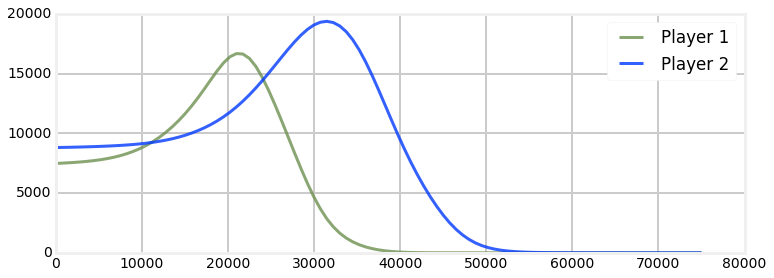

In [10]:
player1.MakeBeliefs(20000)
player2.MakeBeliefs(40000)
    
calc1 = GainCalculator(player1, player2)
calc2 = GainCalculator(player2, player1)

bids, gains = calc1.ExpectedGains()
thinkplot.Plot(bids, gains, label='Player 1')
print('Player 1 optimal bid', max(zip(gains, bids)))

bids, gains = calc2.ExpectedGains()
thinkplot.Plot(bids, gains, label='Player 2')
plt.legend();

Figure 6.4: Expected gain versus bid in a scenario where Player 1’s best guess is
\$20,000 and Player 2’s best guess is \$40,000.

If you overbid, you get nothing. Otherwise we compute the difference
between your bid and the price, which determines your probability of
winning.

If `diff` is less than \$250, you win both showcases. For
simplicity, I assume that both showcases have the same price. Since this
outcome is rare, it doesn’t make much difference.

Finally, we have to compute the probability of winning based on
`diff`:

```python
def ProbWin(self, diff):
    prob = (self.opponent.ProbOverbid() + 
            self.opponent.ProbWorseThan(diff))
    return prob
```

If your opponent overbids, you win. Otherwise, you have to hope that
your opponent is off by more than `diff`. `Player`
provides methods to compute both probabilities:

```python
# class Player:
    def ProbOverbid(self):
        return self.cdf_diff.Prob(-1)

    def ProbWorseThan(self, diff):
        return 1 - self.cdf_diff.Prob(diff)
```

This code might be confusing because the computation is now from the
point of view of the opponent, who is computing, “What is the
probability that I overbid?” and “What is the probability that my bid is
off by more than `diff`?”

Both answers are based on the CDF of `diff`. If the
opponent’s `diff` is less than or equal to -1, you win. If
the opponent’s `diff` is worse than yours, you win. Otherwise
you lose.

Finally, here’s the code that computes optimal bids:

```python
# class Player:
    def OptimalBid(self, guess, opponent):
        self.MakeBeliefs(guess)
        calc = GainCalculator(self, opponent)
        bids, gains = calc.ExpectedGains()
        gain, bid = max(zip(gains, bids))
        return bid, gain
```

Given a guess and an opponent, `OptimalBid` computes the
posterior distribution, instantiates a `GainCalculator`,
computes expected gains for a range of bids and returns the optimal bid
and expected gain. Whew!

Figure [fig.price5] shows the results for both players, based on a
scenario where Player 1’s best guess is \$20,000 and Player 2’s best
guess is \$40,000.

For Player 1 the optimal bid is \$21,000, yielding an expected return of
almost \$16,700. This is a case (which turns out to be unusual) where
the optimal bid is actually higher than the contestant’s best guess.

For Player 2 the optimal bid is \$31,500, yielding an expected return of
almost \$19,400. This is the more typical case where the optimal bid is
less than the best guess.

## Discussion

One of the features of Bayesian estimation is that the result comes in
the form of a posterior distribution. Classical estimation usually
generates a single point estimate or a confidence interval, which is
sufficient if estimation is the last step in the process, but if you
want to use an estimate as an input to a subsequent analysis, point
estimates and intervals are often not much help.

In this example, we use the posterior distribution to compute an optimal
bid. The return on a given bid is asymmetric and discontinuous (if you
overbid, you lose), so it would be hard to solve this problem
analytically. But it is relatively simple to do computationally.

Newcomers to Bayesian thinking are often tempted to summarize the
posterior distribution by computing the mean or the maximum likelihood
estimate. These summaries can be useful, but if that’s all you need,
then you probably don’t need Bayesian methods in the first place.

Bayesian methods are most useful when you can carry the posterior
distribution into the next step of the analysis to perform some kind of
decision analysis, as we did in this chapter, or some kind of
prediction, as we see in the next chapter.